In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import io

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# --- Configuration ---
DATASET_PATH = 'MobiFall_Dataset'
TARGET_SAMPLING_RATE_HZ = 50.0  # Target sampling rate in Hz
TARGET_SAMPLING_PERIOD = f"{int(1000 / TARGET_SAMPLING_RATE_HZ)}ms"
WINDOW_SECONDS = 6
WINDOW_SIZE = int(TARGET_SAMPLING_RATE_HZ * WINDOW_SECONDS) # x samples for y seconds at 50Hz

STEP_SECONDS = 2 # x秒步长
STEP = int(TARGET_SAMPLING_RATE_HZ * STEP_SECONDS)          # 50*x samples for x second step at 50Hz

SENSOR_CODES = ["acc", "gyro", "ori"]
EXPECTED_COLUMNS = {
    "acc": ["acc_x", "acc_y", "acc_z"],
    "gyro": ["gyro_x", "gyro_y", "gyro_z"],
    "ori": ["ori_azimuth", "ori_pitch", "ori_roll"]
}
ALL_FEATURE_COLUMNS = [
    "acc_x", "acc_y", "acc_z", "acc_smv",
    "gyro_x", "gyro_y", "gyro_z", "gyro_smv",
    "ori_azimuth", "ori_pitch", "ori_roll"
]

## 处理原始数据

In [2]:
def load_and_resample_sensor_file(filepath, sensor_code):
    """加载单个传感器文件，转换时间戳并进行重采样。"""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

        # 初始化一个变量作为“标记未找到”的标志
        data_start_line_index = -1

        # 遍历文件中的每一行
        for i, line in enumerate(lines):
            # 检查当前行是否是"@DATA"标记
            if line.strip().upper() == "@DATA":
                # 如果是，则记录下一行的行号并跳出循环
                data_start_line_index = i + 1
                break

        # 检查标记是否被找到
        if data_start_line_index == -1 or data_start_line_index >= len(lines):
            return None

        # 将数据行拼接成单个字符串
        data_string = "".join(lines[data_start_line_index:])

        # 检查字符串是否为空
        if not data_string.strip():
            return None

        # 使用pandas处理数据
        df = pd.read_csv(io.StringIO(data_string), header=None, usecols=[0, 1, 2, 3])
        
        # 检查生成的数据表是否为空
        if df.empty:
            return None

        # 为数据列进行命名
        df.columns = ['timestamp_ns'] + EXPECTED_COLUMNS[sensor_code]

        # 将ns时间戳转换为标准的日期时间格式
        df['timestamp'] = pd.to_datetime(df['timestamp_ns'], unit='ns')

        # 将新的日期时间设置为索引，并删除旧的时间戳列
        df = df.set_index('timestamp').drop(columns=['timestamp_ns'])

        # 按时间索引进行排序
        df = df.sort_index()

        # 将采样时间不均匀的传感器数据，强制转换为频率统一（每20毫秒一个点）的规整数据流，并填补其中的所有空白
        df_resampled = df.resample(TARGET_SAMPLING_PERIOD).mean().interpolate(method='linear', limit_direction='both')

        # 检查当前处理的传感器是否为加速度计 ('acc')
        if sensor_code == 'acc':
            # 安全性检查 - 确认三轴数据都存在
            if all(col in df_resampled.columns for col in ['acc_x', 'acc_y', 'acc_z']):
                # 计算信号幅值向量 (SMV)
                df_resampled['acc_smv'] = np.sqrt(
                    df_resampled['acc_x']**2 + df_resampled['acc_y']**2 + df_resampled['acc_z']**2
                )

        # 如果不是加速度计，则检查是否为陀螺仪 ('gyro')
        elif sensor_code == 'gyro':
            # 对陀螺仪数据执行相同的操作
            if all(col in df_resampled.columns for col in ['gyro_x', 'gyro_y', 'gyro_z']):
                df_resampled['gyro_smv'] = np.sqrt(
                    df_resampled['gyro_x']**2 + df_resampled['gyro_y']**2 + df_resampled['gyro_z']**2
                )

        return df_resampled

    except (pd.errors.EmptyDataError, ValueError):
        return None
    except Exception as e:
        print(f"Error processing file {filepath}: {e}. Skipping.")
        return None

def load_data_from_structured_folders(dataset_root_path):
    """遍历数据集文件夹，处理、对齐并组合每个试验的传感器数据。"""
    print(f"Scanning for data in: {dataset_root_path}")
    if not os.path.isdir(dataset_root_path):
        print(f"ERROR: Dataset root path '{dataset_root_path}' not found.")
        return [], []

    # 存放每一次活动试验（trial）所对应的各个传感器文件的路径（数据文件的位置）
    trial_sensor_files_map = defaultdict(lambda: defaultdict(str))

    # 存放每一次活动试验的元数据（这些数据代表什么，即标签信息）
    trial_metadata_map = {}
    
    # 遍历数据集的每一个文件夹
    for dirpath, _, filenames in os.walk(dataset_root_path):
        # 解析文件夹路径，以确定活动类别和具体活动
        relative_path = os.path.relpath(dirpath, dataset_root_path)
        path_parts = relative_path.split(os.sep)
        # 确保只处理包含实际数据文件的特定层级文件夹
        if len(path_parts) != 3: continue

        # 遍历这些特定文件夹中的每一个文件
        for filename in filenames:
            # 确保只处理.txt文件
            if not filename.endswith(".txt"): continue
            
            # 解析文件名，通过下划线分割以获取各个部分
            fname_parts = filename.replace('.txt', '').split('_')
            # 过滤掉不符合预期格式的文件名
            if len(fname_parts) != 4: continue
            
            # 从文件名部分中提取所需信息
            _, sensor_code, _, trial_no_str = fname_parts
            # 将传感器代码转为小写以保持一致性
            sensor_code = sensor_code.lower()
            # 确保是已知的传感器类型 ('acc', 'gyro', 'ori')
            if sensor_code not in SENSOR_CODES: continue

            # 尝试从路径和文件名中提取并转换所有元数据
            try:
                # 从文件夹路径的第一部分提取受试者ID
                subject_match = re.fullmatch(r'sub(\d+)', path_parts[0], re.IGNORECASE)
                if not subject_match: continue
                subject_id = int(subject_match.group(1))
                
                # 从文件夹路径的第二和第三部分获取类别和活动代码
                category = path_parts[1].upper()
                activity_code = path_parts[2].upper()
                # 将试验编号从字符串转换为整数
                trial_no = int(trial_no_str)
                # 构建完整的文件路径
                filepath = os.path.join(dirpath, filename)
                
                # 创建一个唯一的键来标识这次试验 (受试者, 活动, 试验编号)
                trial_key = (subject_id, activity_code, trial_no)
                # 在映射表中存储该传感器文件的路径
                trial_sensor_files_map[trial_key][sensor_code] = filepath
                # 如果是第一次遇到这个试验，则记录其元数据（类别和活动代码）
                if trial_key not in trial_metadata_map:
                    trial_metadata_map[trial_key] = {"category": category, "activity_code": activity_code}
            except (AttributeError, ValueError):
                # 如果在提取或转换过程中出现任何错误，则跳过该文件
                continue

    # 初始化两个列表，用于存放最终处理好的数据和对应的标签
    processed_trials_data, labels = [], []
    print(f"\nProcessing and combining {len(trial_sensor_files_map)} unique trials...")
    
    # 遍历前面组织好的每一次活动试验（trial）
    for trial_key, sensor_files in trial_sensor_files_map.items():
        # 确保该次试验包含了 acc, gyro, ori 全部三种传感器文件，否则跳过
        if not all(s_code in sensor_files for s_code in SENSOR_CODES): continue

        # 使用字典推导式，为每种传感器加载并重采样数据
        resampled_dfs = {s_code: load_and_resample_sensor_file(sensor_files[s_code], s_code) for s_code in SENSOR_CODES}
        # 如果任何一个文件加载或处理失败（返回了None或空表），则跳过这次试验
        if any(df is None or df.empty for df in resampled_dfs.values()): continue

        try:
            # --- 时间对齐关键步骤 ---
            # 找到三个传感器数据中最晚的开始时间
            common_start = max(df.index.min() for df in resampled_dfs.values())
            # 找到三个传感器数据中最早的结束时间
            common_end = min(df.index.max() for df in resampled_dfs.values())
            # 如果没有重叠的时间窗口，则跳过
            if common_start >= common_end: continue

            # 将三个数据表都裁剪到共同的时间范围内
            aligned_dfs = [resampled_dfs[s_code][common_start:common_end].reset_index(drop=True) for s_code in SENSOR_CODES]
            # 确保对齐后的数据表长度一致且不为空，否则跳过
            if not all(len(df) > 0 and len(df) == len(aligned_dfs[0]) for df in aligned_dfs): continue
            
            # --- 数据合并 ---
            # 按列（axis=1）将三个对齐后的数据表拼接成一个宽表
            combined_df = pd.concat(aligned_dfs, axis=1)
            
            # 再次检查并确保列名正确
            if len(combined_df.columns) == len(ALL_FEATURE_COLUMNS):
                 combined_df.columns = ALL_FEATURE_COLUMNS
            else:
                 continue # 如果列数不匹配则跳过

            # 如果合并后的数据长度不足一个序列窗口（4秒），则跳过
            if len(combined_df) < WINDOW_SIZE: continue
            
            # --- 数据和标签存储 ---
            # 将处理好的数据（转换为Numpy数组）存入列表
            processed_trials_data.append(combined_df.values)
            # 根据元数据判断该试验是"FALLS"还是"ADL"，并存入标签（1代表跌倒，0代表非跌倒）
            labels.append(1 if trial_metadata_map[trial_key]["category"] == "FALLS" else 0)
            
        except Exception:
            # 捕获任何在对齐和合并过程中可能出现的意外错误，并跳过该试验
            continue

    print(f"Successfully processed and combined sensor data for {len(processed_trials_data)} trials.")
    # 返回包含所有处理好的试验数据和标签的列表
    return processed_trials_data, labels

def create_sequences(data_list, label_list, seq_length, step):
    """使用滑动窗口从试验数据创建序列。"""
    # 初始化用于存放最终序列和对应标签的列表
    X, y = [], []
    # 遍历每一次活动试验的数据
    for i, trial_data in enumerate(data_list):
        trial_label = label_list[i]
        # 在单次试验数据上，按指定的步长（step）移动窗口
        for j in range(0, len(trial_data) - seq_length + 1, step):
            # 截取一个固定长度（seq_length）的片段作为序列
            X.append(trial_data[j:(j + seq_length)])
            # 为这个序列分配对应的标签
            y.append(trial_label)
            
    if not X: return np.array([]), np.array([])
    # 将列表转换为Numpy数组后返回
    return np.array(X), np.array(y)

SensorDataSequences, SensorLabelSequences = np.array([]), np.array([])

DATASEQ_PATH = 'SensorDataSequences_reg.npy'
LABELSEQ_PATH = 'SensorLabelSequences_reg.npy'

if os.path.exists(DATASEQ_PATH) and os.path.exists(LABELSEQ_PATH):
    print("Found existing npy files. Loading...")
    SensorDataSequences = np.load(DATASEQ_PATH)
    print(f"Loaded dataset shape: X={SensorDataSequences.shape}")
    SensorLabelSequences = np.load(LABELSEQ_PATH)
    print(f"Loaded dataset shape: y={SensorLabelSequences.shape}")
else:
    trial_arrays, trial_labels = load_data_from_structured_folders(DATASET_PATH)
    SensorDataSequences, SensorLabelSequences = create_sequences(trial_arrays, trial_labels, WINDOW_SIZE, STEP)
    print(f"The shape of the final dataset is: X={SensorDataSequences.shape}, y={SensorLabelSequences.shape}")
    np.save(DATASEQ_PATH, SensorDataSequences)
    np.save(LABELSEQ_PATH, SensorLabelSequences)
    print("Saved processed dataset to npy files.")

Found existing npy files. Loading...
Loaded dataset shape: X=(4156, 300, 11)
Loaded dataset shape: y=(4156,)


## 自回归模型定义

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        # outputs shape: (batch_size, seq_len, hidden_dim)
        # hidden, cell shapes: (n_layers, batch_size, hidden_dim)
        outputs, (hidden, cell) = self.lstm(x)
        # 将最后一个时间步的隐藏状态和细胞状态作为上下文向量
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(output_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        # x shape: (batch_size, 1, output_dim) - 初始输入是序列的最后一个点
        # hidden, cell shapes: (n_layers, batch_size, hidden_dim)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        # output shape: (batch_size, 1, hidden_dim)
        prediction = self.fc(output)
        # prediction shape: (batch_size, 1, output_dim)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source shape: (batch_size, input_len, input_dim)
        # target shape: (batch_size, target_len, output_dim)
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_dim = self.decoder.output_dim

        # 存储解码器输出的张量
        outputs = torch.zeros(batch_size, target_len, target_dim).to(self.device)

        # 编码器传递上下文向量
        hidden, cell = self.encoder(source)

        # 解码器的第一个输入是源序列的最后一个时间点
        # 这里为了简化，使用一个全零的输入开始
        decoder_input = torch.zeros(batch_size, 1, target_dim).to(self.device)

        for t in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1, :] = output

            # 决定是否使用 "Teacher Forcing"
            teacher_force = np.random.random() < teacher_forcing_ratio
            # 如果使用，下一个输入是真实的标签；否则，使用模型自己的预测
            decoder_input = target[:, t:t+1, :] if teacher_force else output

        return outputs

## 数据集类定义

In [4]:
# --- 基本设置 ---
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 为了结果可复现，设置随机种子
torch.manual_seed(42)
np.random.seed(42)


class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, target_len):
        self.data = data
        self.input_len = input_len
        self.target_len = target_len
        # 总序列长度必须等于 input_len + target_len
        assert data.shape[1] == input_len + target_len, "Data sequence length does not match input_len + target_len"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        x = sequence[:self.input_len]
        y = sequence[self.input_len:]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# --- 定义序列长度 ---
# 使用前200个点来预测后100个点
INPUT_SEQ_LEN = 200
TARGET_SEQ_LEN = 100
TOTAL_SEQ_LEN = INPUT_SEQ_LEN + TARGET_SEQ_LEN

Using device: cuda


## 训练函数定义

In [5]:
mae_criterion = nn.L1Loss() # MAE Loss

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    """
    模型训练主函数
    """
    best_val_loss = float('inf')

    train_loss_history = []
    val_loss_history = []
    val_mae_history = []

    for epoch in range(epochs):
        
        # --- 训练模式 ---
        model.train()
        train_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs, targets)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # --- 评估模式 ---
        model.eval()
        val_loss = 0
        val_mae = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs, targets, teacher_forcing_ratio=0) 
                
                loss = criterion(outputs, targets) # MSE Loss
                mae = mae_criterion(outputs, targets) # MAE Loss
                
                val_loss += loss.item()
                val_mae += mae.item() # 累加MAE

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae = val_mae / len(val_loader) # 计算平均MAE

        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        val_mae_history.append(avg_val_mae)

        print(f'Epoch: {epoch+1:02}')
        print(f'Train Loss: {avg_train_loss:.4f},  Val. Loss: {avg_val_loss:.4f},  Val. MAE: {avg_val_mae:.4f}')

        # 保存表现最好的模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'autoregression_feature_extractor_model.pt')
            print(f'\tBest model saved with validation loss: {best_val_loss:.4f}')

    return train_loss_history, val_loss_history, val_mae_history



## 训练启动代码

In [6]:
# 1. 设置超参数
INPUT_DIM = 11      # 每个时间点的特征数
OUTPUT_DIM = 11     # 输出维度和输入维度相同
HIDDEN_DIM = 64     # 隐藏层维度，这个值决定了特征向量的维度，可以调整
N_LAYERS = 2        # LSTM层数
DROPOUT = 0.1
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001

# 1. 划分数据集
train_data, val_data = train_test_split(SensorDataSequences, test_size=0.2, random_state=42)

# 2. 创建并拟合Scaler
# 需要将数据 reshape 成 2D 来进行拟合
# (num_samples * seq_len, num_features)
num_train_samples, seq_len, num_features = train_data.shape
num_val_samples = val_data.shape[0]

# 只用训练数据来拟合Scaler
scaler = StandardScaler()
scaler.fit(train_data.reshape(-1, num_features))

# 3. 标准化训练集和验证集
train_data_scaled = scaler.transform(train_data.reshape(-1, num_features)).reshape(num_train_samples, seq_len, num_features)
val_data_scaled = scaler.transform(val_data.reshape(-1, num_features)).reshape(num_val_samples, seq_len, num_features)

print("Data successfully standardized.")
print("Original train data mean (first feature):", np.mean(train_data[:,:,0]))
print("Scaled train data mean (first feature):", np.mean(train_data_scaled[:,:,0])) # 应该接近 0
print("Scaled train data std (first feature):", np.std(train_data_scaled[:,:,0]))

# 保存Scaler以便后续使用
scaler_filename = "autoregression_timeseries_data_scaler.save"
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")
      
    
# 3. 创建Dataset和DataLoader
train_dataset = TimeSeriesDataset(train_data_scaled, INPUT_SEQ_LEN, TARGET_SEQ_LEN)
val_dataset = TimeSeriesDataset(val_data_scaled, INPUT_SEQ_LEN, TARGET_SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. 实例化模型、优化器和损失函数
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss() # 均方误差损失，适合回归预测任务

train_loss_history, val_loss_history, val_mae_history = [], [], []

# 5. 开始训练
print("\nStarting model training...")
train_loss_history, val_loss_history, val_mae_history = train_model(model, train_loader, val_loader, optimizer, criterion, EPOCHS)
print("Training finished.")

Data successfully standardized.
Original train data mean (first feature): -0.23023207997009373
Scaled train data mean (first feature): -1.6859215365295405e-14
Scaled train data std (first feature): 1.0000000000000915
Scaler saved to autoregression_timeseries_data_scaler.save

Starting model training...
Epoch: 01
Train Loss: 0.9527,  Val. Loss: 0.9725,  Val. MAE: 0.6714
	Best model saved with validation loss: 0.9725
Epoch: 02
Train Loss: 0.7044,  Val. Loss: 0.7859,  Val. MAE: 0.5671
	Best model saved with validation loss: 0.7859
Epoch: 03
Train Loss: 0.5649,  Val. Loss: 0.7036,  Val. MAE: 0.5203
	Best model saved with validation loss: 0.7036
Epoch: 04
Train Loss: 0.4929,  Val. Loss: 0.7347,  Val. MAE: 0.5479
Epoch: 05
Train Loss: 0.4266,  Val. Loss: 0.7893,  Val. MAE: 0.5738
Epoch: 06
Train Loss: 0.3867,  Val. Loss: 0.7585,  Val. MAE: 0.5570
Epoch: 07
Train Loss: 0.3520,  Val. Loss: 0.7615,  Val. MAE: 0.5538
Epoch: 08
Train Loss: 0.3252,  Val. Loss: 0.6736,  Val. MAE: 0.4894
	Best model

## 绘制训练指标图

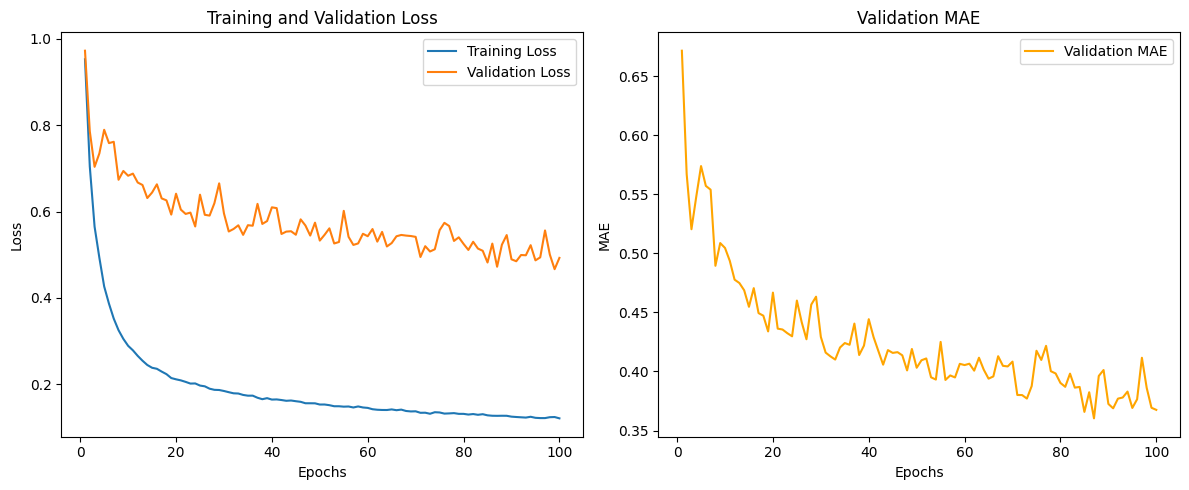

In [7]:
import matplotlib.pyplot as plt

# 6. 绘制训练指标图
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制MAE曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, val_mae_history, label='Validation MAE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()